In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import datetime
import quantstats as qs
import yfinance as yf
import warnings
import seaborn as sns

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU

from csv import writer

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

import sys
sys.path.insert(0,'/Users/orentapiero/Ducuments/MyResearch/btc_research/')

from btc_functions.glassnode import *
from btc_functions.import_data import get_glassnode_price,get_glassnode_data
from btc_functions.variable_list_urls import *
from btc_functions.utilities import strided_app,strided_app2

plt.rcParams['figure.figsize'] = [18, 10]
sns.set()

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
Urls['transfers_volume_sum'] = 'https://api.glassnode.com/v1/metrics/transactions/transfers_volume_sum'
Urls['ssr'] = 'https://api.glassnode.com/v1/metrics/indicators/ssr'

In [3]:
ohlc = get_glassnode_price()
ohlc = ohlc.rename(columns = {'o':'Open','h':'High','l':'Low','c':'Close'})
ohlc = ohlc.loc[:'2019']


In [4]:
data = ohlc.copy()
data['sma20'] = data['Close'].rolling(20).mean()
data['sma50'] = data['Close'].rolling(50).mean()
data['sma200'] = data['Close'].rolling(200).mean()
data = data.dropna()

In [5]:
def create_mat(data,lookback):
    X = []
    y = []
    for i in range(len(data) - lookback - 1):
        t = []
        for j in range(0, lookback):
            t.append(data[[(i + j)], :])
        X.append(t)
        y.append(data[i + lookback, 0])

    X, y = np.array(X), np.array(y)
    X = X.reshape(X.shape[0], lookback, X.shape[-1])
    return X,y

In [7]:
strided_dates = strided_app(data.index.values,1200,30)

train_dates,cv_dates = strided_dates[0,:-30],strided_dates[0,-30:]

train_data,cv_data = data.loc[train_dates].values,data.loc[cv_dates].values

scale = StandardScaler().fit(train_data)

s_train = scale.transform(train_data)
s_cv = scale.transform(cv_data)


X_train,y_train = create_mat(s_train,1)
X_cv,y_cv = create_mat(s_cv,1)

model = Sequential()
model.add(Dropout(0.2, input_shape=(X_train.shape[1], 7)))  # can adjust dropout %
model.add(Activation('relu')) 
model.add(LSTM(units=30, return_sequences=True, input_shape=(X_train.shape[1], 7)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))
# model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=500, batch_size=32) 
predicted_value_s = model.predict(X_cv)
scale_y = MinMaxScaler(feature_range=(0, 1)).fit(train_data[:,0].reshape(-1,1))
predicted_value = scale_y.inverse_transform(predicted_value_s)

2022-04-07 12:18:27.125396: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/500
37/37 [==============================] - 2s 2ms/step - loss: 0.9534
Epoch 2/500
37/37 [==============================] - 0s 2ms/step - loss: 0.5000
Epoch 3/500
37/37 [==============================] - 0s 2ms/step - loss: 0.1018
Epoch 4/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0777
Epoch 5/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0839
Epoch 6/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0725
Epoch 7/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0684
Epoch 8/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0609
Epoch 9/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0575
Epoch 10/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0573
Epoch 11/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0579
Epoch 12/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0585
Epoch 13/500
37/37 [=================

37/37 [==============================] - 0s 2ms/step - loss: 0.0270
Epoch 103/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0241
Epoch 104/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0282
Epoch 105/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0244
Epoch 106/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0274
Epoch 107/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0261
Epoch 108/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0238
Epoch 109/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0222
Epoch 110/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0236
Epoch 111/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0248
Epoch 112/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0224
Epoch 113/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0236
Epoch 114/500
37/37 [=========

37/37 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 203/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 204/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 205/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 206/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 207/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 208/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0157
Epoch 209/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 210/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 211/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0180
Epoch 212/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 213/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0186
Epoch 214/500
37/37 [=========

37/37 [==============================] - 0s 2ms/step - loss: 0.0201
Epoch 303/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 304/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 305/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0178
Epoch 306/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0185
Epoch 307/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 308/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 309/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 310/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 311/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 312/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 313/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 314/500
37/37 [=========

37/37 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 403/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 404/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 405/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 406/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 407/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 408/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 409/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 410/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 411/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 412/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 413/500
37/37 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 414/500
37/37 [=========

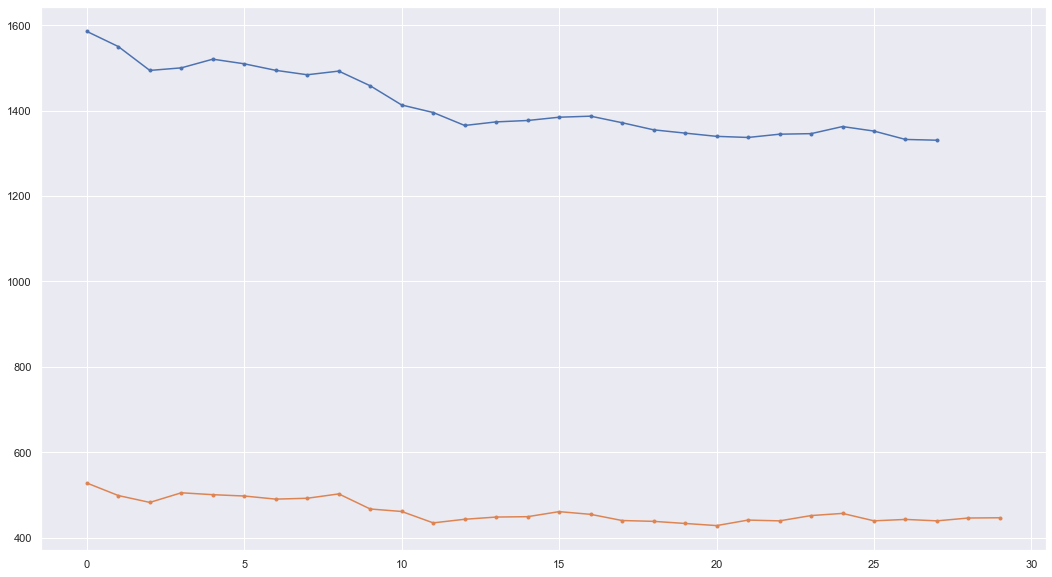

In [8]:
plt.plot(predicted_value,'.-')
plt.plot(cv_data[:,0],'.-')

In [ ]:
scale_y

In [ ]:
data.values